In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from visualization import ANN
%matplotlib widget

## For random weights

In [14]:
model = ANN()
model = model.cuda()
model = model.eval()

## For trained weights

In [3]:
model = ANN.load_from_checkpoint(r"C:\Users\m.minhas\DeepLearning\GIT_Repos_Manp\embeddings-visualization\lightning_logs\version_5\checkpoints\epoch=4-step=8594.ckpt")
model = model.cuda()
model.eval()

## Prepare the test set and inject noisy outliers

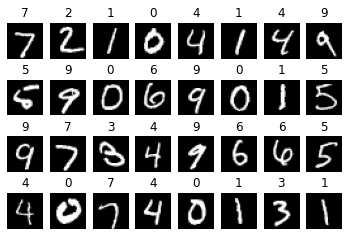

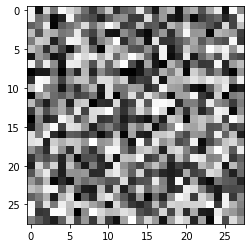

In [11]:
transform = transforms.Compose([transforms.ToTensor()])
data = MNIST(".", train=False, download=True, transform=transform)
test_sample = torch.unsqueeze(data.data[:32].clone().cuda(),1).float()
plt.figure()
for i in range(32):
    plt.subplot(4,8,i+1)
    plt.imshow(data.data[i], cmap='gray')
    plt.axis('off')
    plt.title(data.targets[i].item())
np.random.seed(19)
num_wrong_samples = 1000
random_indices = np.random.uniform(0, 10000, num_wrong_samples).astype(np.uint8)
outlier_list = []
for i in range(num_wrong_samples):
    outlier = np.random.uniform(0,255, (28,28)).astype(np.uint8)
    outlier_list.append(outlier)
plt.figure()
plt.imshow(outlier, cmap='gray')
for idx in range(num_wrong_samples):
    data.data[random_indices[idx]] = torch.ByteTensor(outlier_list[idx])
    data.targets[random_indices[idx]] = 10
dataloader = DataLoader(data, batch_size=32)

## Do predictions

In [6]:
test_imgs = torch.zeros((0, 1, 28, 28), dtype=torch.float32)
test_predictions = []
test_targets = []
test_embeddings = torch.zeros((0, 100), dtype=torch.float32)
for x,y in dataloader:
    x = x.cuda()
    embeddings, logits = model(x)
    preds = torch.argmax(logits, dim=1)
    test_predictions.extend(preds.detach().cpu().tolist())
    test_targets.extend(y.detach().cpu().tolist())
    test_embeddings = torch.cat((test_embeddings, embeddings.detach().cpu()), 0)
    test_imgs = torch.cat((test_imgs, x.detach().cpu()), 0)
test_imgs = np.array(test_imgs)
test_embeddings = np.array(test_embeddings)
test_targets = np.array(test_targets)
test_predictions = np.array(test_predictions)

## Look at few sample predictions

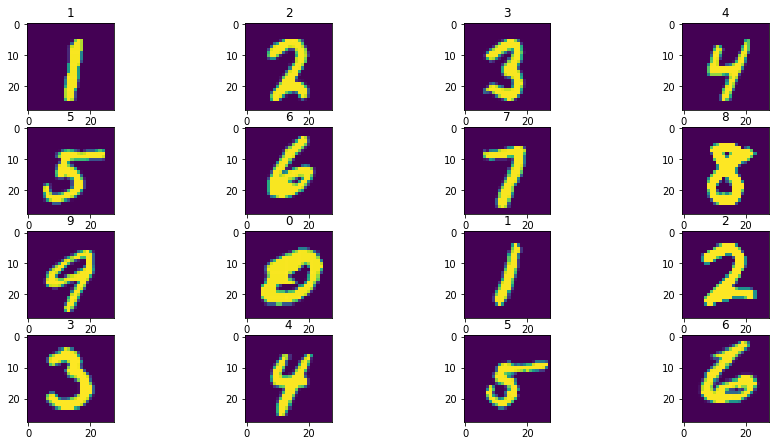

In [10]:
plt.figure(figsize=(15,15))
for i in range(16):
    plt.subplot(8,4,i+1).set_title(y[i].detach().cpu().item())
    plt.imshow(x[i][0].detach().cpu())

## t-SNE 2D 

In [17]:
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(test_embeddings)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 2.573s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.184018
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.138519
[t-SNE] KL divergence after 1000 iterations: 1.750518


## t-SNE 2D of test embeddings from random weights

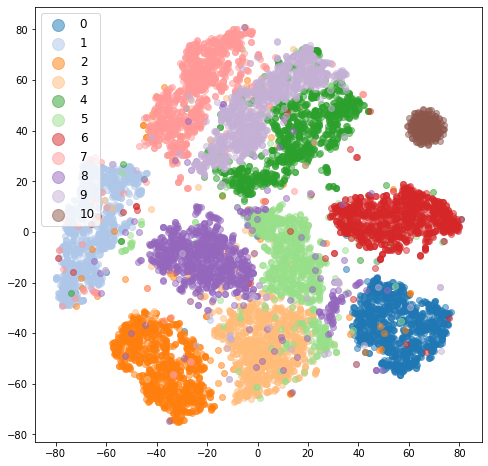

In [22]:
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 11
for lab in range(num_categories):
    indices = test_targets==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

## t-SNE 2D of test embeddings from trained weights

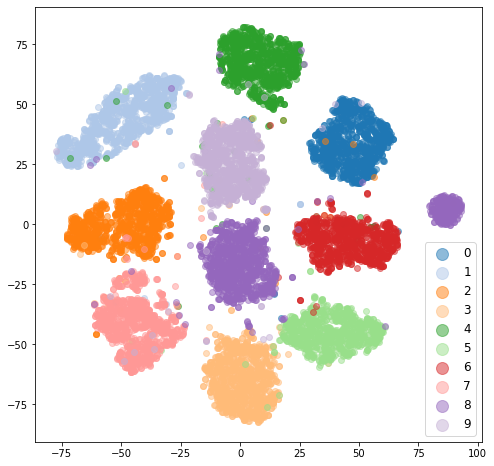

In [12]:
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 10
for lab in range(num_categories):
    indices = test_predictions==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

## PCA 2D

In [8]:
pca = PCA(n_components=2)
pca.fit(test_embeddings)
pca_proj = pca.transform(test_embeddings)

In [24]:
pca.explained_variance_ratio_

array([0.16178058, 0.08613876], dtype=float32)

## PCA 2D of test embeddings from random weights

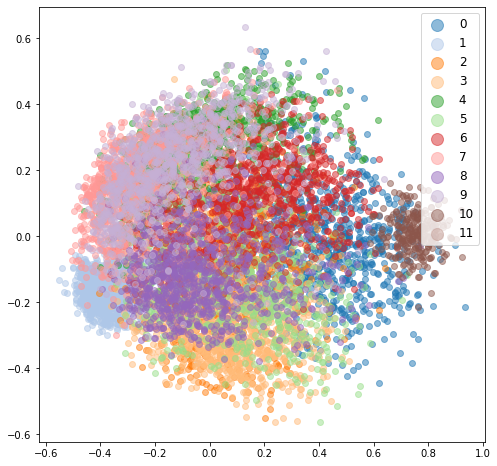

In [25]:
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 11
for lab in range(num_categories):
    indices = test_targets==lab
    ax.scatter(pca_proj[indices,0],pca_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

## PCA 2D of test embeddings from random weights

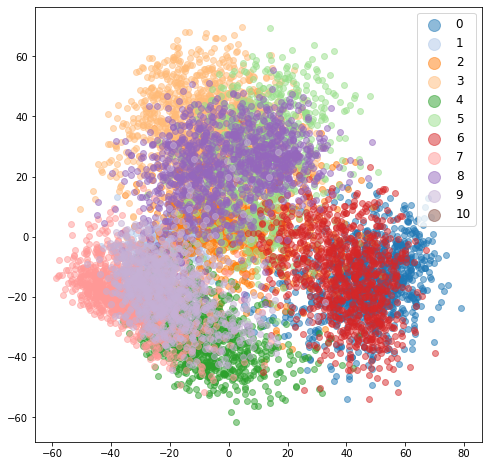

In [9]:
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 10
for lab in range(num_categories):
    indices = test_predictions==lab
    ax.scatter(pca_proj[indices,0],pca_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()